In [1]:
import pypsa
import yaml
import pandas as pd
import numpy as np
import geopandas as gpd
import xarray as xr
import cartopy.crs as ccrs
import cartopy

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.colors as mcolors
from matplotlib.patches import Circle, Patch
from matplotlib.legend_handler import HandlerPatch

from pypsa.descriptors import get_switchable_as_dense as as_dense

from shapely import wkt
import sys, os

PATH = "../subworkflows/"
SCRIPTS_PATH = "pypsa-eur-sec/scripts/"

sys.path.append(os.path.join(PATH, SCRIPTS_PATH))
from plot_network import make_legend_circles_for, assign_location
from helper import override_component_attrs
from build_gas_input_locations import build_gas_input_locations, load_bus_regions

plt.style.use(["bmh", "matplotlibrc"])
xr.set_options(display_style="html")

%matplotlib inline

In [2]:
OUTPUT = "../../results"

CLUSTERS = 128
LL = 2.0
OPTS = "Co2L0-3H-T-H-B-I-A-solar+p3-linemaxext15"
RUN = "v8"
SCENARIO = f"elec_s_{CLUSTERS}_lv{LL}__{OPTS}_2030"
OVERRIDES = PATH + "pypsa-eur-sec/data/override_component_attrs"

In [3]:
with open(PATH + "pypsa-eur-sec/config.yaml") as file:
    config = yaml.safe_load(file)

In [4]:
fn = f"{PATH}/pypsa-eur/resources/regions_onshore_elec_s_{CLUSTERS}.geojson"
nodes = gpd.read_file(fn).set_index("name")

fn = f"{PATH}/pypsa-eur/resources/regions_offshore_elec_s_{CLUSTERS}.geojson"
offnodes = gpd.read_file(fn).set_index("name")

fn = f"{PATH}/pypsa-eur/resources/country_shapes.geojson"
cts = gpd.read_file(fn).set_index("name")

regions = pd.concat(
    [
        gpd.read_file(f"{PATH}/pypsa-eur/resources/regions_onshore.geojson"),
        gpd.read_file(f"{PATH}/pypsa-eur/resources/regions_offshore.geojson"),
    ]
)
regions = regions.dissolve("name")

fn = f"{PATH}/pypsa-eur/resources/regions_onshore.geojson"
onregions = gpd.read_file(fn).set_index("name")

fn = f"{PATH}/pypsa-eur/resources/regions_onshore.geojson"
offregions = gpd.read_file(fn).set_index("name")

epsg = 3035
regions["Area"] = regions.to_crs(epsg=epsg).area.div(1e6)
onregions["Area"] = onregions.to_crs(epsg=epsg).area.div(1e6)
offregions["Area"] = offregions.to_crs(epsg=epsg).area.div(1e6)
nodes["Area"] = nodes.to_crs(epsg=epsg).area.div(1e6)

In [5]:
europe_shape = nodes.dissolve()
europe_shape.index = ["EU"]

In [6]:
minx, miny, maxx, maxy = europe_shape.explode(ignore_index=True).total_bounds
BOUNDARIES = [minx, maxx - 4, miny, maxy]

In [7]:
overrides = override_component_attrs(OVERRIDES)
fn = f"{PATH}/pypsa-eur-sec/results/{RUN}/prenetworks/{SCENARIO}.nc"
n = pypsa.Network(fn, override_component_attrs=overrides)

INFO:pypsa.io:Imported network elec_s_128_lv2.0__Co2L0-3H-T-H-B-I-A-solar+p3-linemaxext15_2030.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


In [8]:
unique_link_carriers = n.links.carrier.unique()
GAS_NETWORK = "gas pipeline" in unique_link_carriers
H2_NETWORK = any("H2 pipeline" in ulc for ulc in unique_link_carriers)

## Utilities

In [9]:
class HandlerCircle(HandlerPatch):
    """
    Legend Handler used to create circles for legend entries.

    This handler resizes the circles in order to match the same dimensional
    scaling as in the applied axis.
    """

    def create_artists(
        self, legend, orig_handle, xdescent, ydescent, width, height, fontsize, trans
    ):
        fig = legend.get_figure()
        ax = legend.axes

        unit = np.diff(ax.transData.transform([(0, 0), (1, 1)]), axis=0)[0][1]
        radius = orig_handle.get_radius() * unit * (72 / fig.dpi)
        center = 5 - xdescent, 3 - ydescent
        p = plt.Circle(center, radius)
        self.update_prop(p, orig_handle, legend)
        p.set_transform(trans)
        return [p]


def add_legend_circles(
    ax, sizes, labels, scale=1, srid=None, patch_kw={}, legend_kw={}
):

    if srid is not None:
        area_correction = projected_area_factor(ax, n.srid) ** 2
        sizes = [s * area_correction for s in sizes]

    handles = make_legend_circles_for(sizes, scale, **patch_kw)

    legend = ax.legend(
        handles, labels, handler_map={Circle: HandlerCircle()}, **legend_kw
    )

    ax.add_artist(legend)


def add_legend_lines(ax, sizes, labels, scale=1, patch_kw={}, legend_kw={}):

    handles = [Line2D([0], [0], linewidth=s / scale, **patch_kw) for s in sizes]

    legend = ax.legend(handles, labels, **legend_kw)

    ax.add_artist(legend)


def add_legend_patch(ax, colors, labels, patch_kw={}, legend_kw={}):

    handles = [Patch(facecolor=c, **patch_kw) for c in colors]

    legend = ax.legend(handles, labels, **legend_kw)

    ax.add_artist(legend)

## Original Gas and Electricity Network

In [27]:
def plot_original_gas_network(network):

    n = network.copy()

    lw_factor = 20e3
    color = "indianred"

    n.mremove("Bus", n.buses.index[n.buses.carrier != "AC"])
    n.mremove("Link", n.links.index[~n.links.carrier.str.contains("gas pipeline")])

    n.links.bus0 = n.links.bus0.str.replace(" gas", "")
    n.links.bus1 = n.links.bus1.str.replace(" gas", "")

    crs = ccrs.EqualEarth()

    fig, ax = plt.subplots(figsize=(7, 6), subplot_kw={"projection": crs})

    n.plot(
        geomap=True,
        ax=ax,
        bus_sizes=0.005,
        bus_colors="k",
        link_colors=color,
        link_widths=n.links.p_nom / lw_factor,
        branch_components=["Link"],
    )

    handles = []
    labels = []

    for s in (100, 50, 20):
        handles.append(plt.Line2D([0], [0], color=color, linewidth=s * 1e3 / lw_factor))
        labels.append("{} GW".format(s))
    l1_1 = ax.legend(
        handles,
        labels,
        loc="upper left",
        bbox_to_anchor=(0.05, 1.01),
        frameon=False,
        labelspacing=0.8,
        handletextpad=1.5,
        title="Today's gas transmission",
    )
    ax.add_artist(l1_1)

    fig.savefig(f"{OUTPUT}/gas-network-today-map.pdf", bbox_inches="tight")

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning:

__len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning:

Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning:

__len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:82

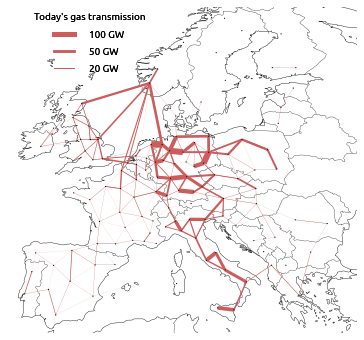

In [28]:
plot_original_gas_network(n)

In [29]:
def plot_original_electricity_network(network):

    n = network.copy()

    lw_factor = 3e3

    n.mremove("Bus", n.buses.index[n.buses.carrier != "AC"])
    n.mremove("Link", n.links.index[~n.links.carrier.str.contains("DC")])

    crs = ccrs.EqualEarth()

    fig, ax = plt.subplots(figsize=(7, 6), subplot_kw={"projection": crs})

    n.plot(
        geomap=True,
        ax=ax,
        bus_sizes=0.005,
        bus_colors="k",
        link_colors=n.links.p_nom.apply(
            lambda x: "darkseagreen" if x > 0 else "skyblue"
        ),
        link_widths=1.5,
        line_widths=n.lines.s_nom / lw_factor,
    )

    handles = []
    labels = []

    for s in (20, 10):
        handles.append(
            plt.Line2D([0], [0], color="rosybrown", linewidth=s * 1e3 / lw_factor)
        )
        labels.append("{} GW HVAC today".format(s))
    l1_1 = ax.legend(
        handles,
        labels,
        loc="upper left",
        bbox_to_anchor=(0.025, 1.01),
        frameon=False,
        labelspacing=0.8,
        handletextpad=1.5,
        # title='Today\'s AC transmission'
    )
    ax.add_artist(l1_1)

    handles = [
        Line2D([0], [0], color="darkseagreen", lw=1.5),
        Line2D([0], [0], color="skyblue", lw=1.5),
    ]
    l2 = ax.legend(
        handles,
        ["HVDC existing", "HVDC planned"],
        frameon=False,
        loc=[0.04, 0.78],
        labelspacing=0.8,
        handletextpad=1.5,
    )

    ax.add_artist(l2)

    fig.savefig(f"{OUTPUT}/electricity-network-today-map.pdf", bbox_inches="tight")

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning:

__len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning:

Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning:

__len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:82

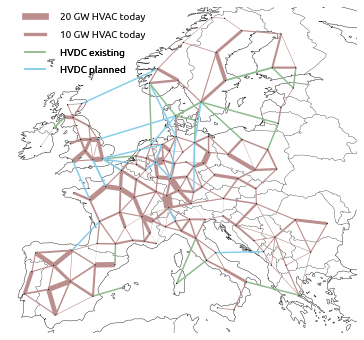

In [30]:
plot_original_electricity_network(n)

## Stats: Per-Country Potentials

In [31]:
def country_potentials(n):

    return (
        n.generators.p_nom_max.groupby([n.generators.carrier, n.generators.bus.str[:2]])
        .sum()
        .div(1e3)
        .unstack(0)
        .round(1)
        .replace([np.inf, -np.inf], np.nan)
        .dropna(axis=1, how="all")
        .fillna(0.0)
    )

In [32]:
p = country_potentials(n)
p

carrier,offwind-ac,offwind-dc,onwind,solar,solar rooftop
bus,,,,,
AL,3.7,0.0,67.5,53.8,2.6
AT,0.0,0.0,132.3,165.9,8.0
BA,0.0,0.0,138.4,88.2,3.8
BE,3.0,9.9,15.5,105.9,11.2
BG,5.4,0.0,145.5,234.1,7.4
CH,0.0,0.0,77.6,125.0,7.8
CZ,0.0,0.0,104.1,209.4,10.4
DE,15.9,44.7,489.2,1079.1,80.1
DK,54.3,72.2,73.4,144.3,4.0


In [35]:
p.to_csv(f"../../results/country_potentials.csv")

## Maps: regional demands

In [14]:
def get_oil_demand():

    fn = f"{PATH}pypsa-eur-sec/resources/industrial_energy_demand_elec_s_{CLUSTERS}_2030.csv"
    industrial_demand = pd.read_csv(fn, index_col=0)

    fn = f"{PATH}pypsa-eur-sec/resources/pop_layout_elec_s_{CLUSTERS}.csv"
    pop_layout = pd.read_csv(fn, index_col=0)

    fn = f"{PATH}pypsa-eur-sec/resources/energy_totals.csv"
    energy_totals = pd.read_csv(fn, index_col=0)
    nodal_energy_totals = energy_totals.loc[pop_layout.ct].fillna(0.0)
    nodal_energy_totals.index = pop_layout.index
    nodal_energy_totals = nodal_energy_totals.multiply(pop_layout.fraction, axis=0)

    oil = [
        "total international aviation",
        "total domestic aviation",
        "total agriculture machinery",
    ]

    return industrial_demand["naphtha"] + nodal_energy_totals[oil].sum(axis=1)

In [15]:
def get_biomass_demand():

    fn = f"{PATH}pypsa-eur-sec/resources/industrial_energy_demand_elec_s_{CLUSTERS}_2030.csv"
    industrial_demand = pd.read_csv(fn, index_col=0)

    return industrial_demand["solid biomass"]

In [16]:
title = {
    "electricity": "Electricity Demand [TWh/a]",
    "H2": "Hydrogen Demand [TWh/a]",
    "heat": "Heat Demand [TWh/a]",
    "solid biomass": "Solid Biomass Demand [TWh/a]",
    "gas": "Methane Demand [TWh/a]",
    "oil": "Oil Demand [TWh/a]",
    "process emission": "Process Emissions [MtCO2/a]",
}

cmap = {
    "electricity": "Blues",
    "H2": "RdPu",
    "heat": "Reds",
    "solid biomass": "Greens",
    "gas": "Oranges",
    "oil": "Greys",
    "process emission": "Greys",
}

regex = {
    "electricity": r"(electricity|EV)",
    "H2": r"(H2|fuel cell)",
    "heat": r"heat",
    "solid biomass": r"biomass",
    "oil": r"( oil|naphtha|kerosene)",
    "gas": r"gas",
}

In [17]:
demand = as_dense(n, "Load", "p_set").div(1e6)  # TWh
demand_grouped = demand.groupby(
    [n.loads.carrier, n.loads.bus.map(n.buses.location)], axis=1
).sum()
demand_by_region = (n.snapshot_weightings.generators @ demand_grouped).unstack(level=0)

In [40]:
def plot_regional_demands(df, geodf, carrier, series=None):

    if series is None:
        series = df.filter(regex=regex[carrier]).sum(axis=1).drop("EU")

    proj = ccrs.EqualEarth()
    geodf = geodf.to_crs(proj.proj4_init)

    fig, ax = plt.subplots(figsize=(7, 7), subplot_kw={"projection": proj})

    geodf.plot(
        ax=ax,
        column=series,
        # transform=ccrs.PlateCarree(),
        cmap=cmap[carrier],
        linewidths=0,
        legend=True,
        legend_kwds={"label": title[carrier], "shrink": 0.7, "extend": "max"},
    )

    ax.add_feature(cartopy.feature.COASTLINE.with_scale("50m"), linewidth=0.2, zorder=2)
    ax.add_feature(cartopy.feature.BORDERS.with_scale("50m"), linewidth=0.2, zorder=2)

    plt.gca().outline_patch.set_visible(False)
    ax.set_facecolor("white")

    plt.savefig(f"{OUTPUT}/demand-map-{carrier}.pdf", bbox_inches="tight")

/tmp/ipykernel_42971/2807608128.py:24: DeprecationWarning:

The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning:

__len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning:

Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning:

__len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `

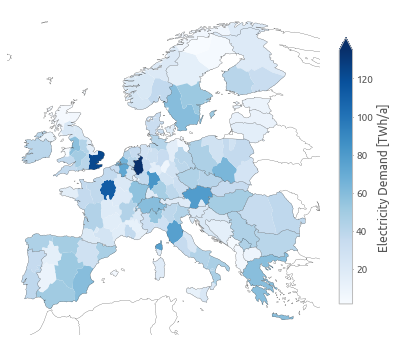

In [41]:
plot_regional_demands(demand_by_region, nodes, "electricity")

/tmp/ipykernel_42971/2807608128.py:24: DeprecationWarning:

The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning:

__len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning:

Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning:

__len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `

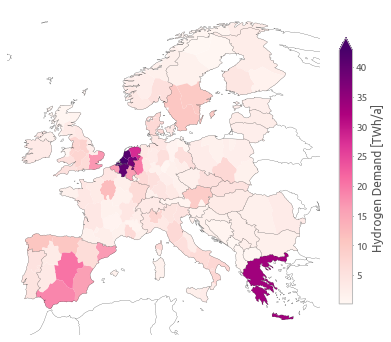

In [42]:
plot_regional_demands(demand_by_region, nodes, "H2")

/tmp/ipykernel_42971/2807608128.py:24: DeprecationWarning:

The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning:

__len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning:

Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning:

__len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `

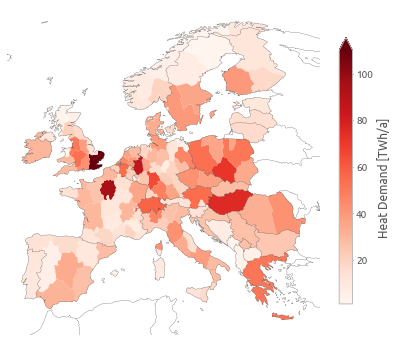

In [43]:
plot_regional_demands(demand_by_region, nodes, "heat")

/tmp/ipykernel_42971/2807608128.py:24: DeprecationWarning:

The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning:

__len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning:

Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning:

__len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `

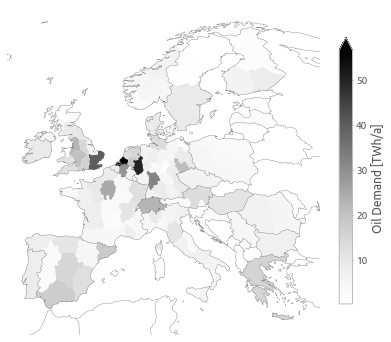

In [50]:
plot_regional_demands(demand_by_region, nodes, "oil", series=get_oil_demand())

/tmp/ipykernel_42971/2807608128.py:24: DeprecationWarning:

The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning:

__len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning:

Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning:

__len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `

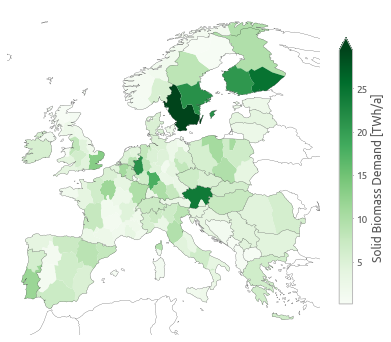

In [51]:
plot_regional_demands(
    demand_by_region, nodes, "solid biomass", series=get_biomass_demand()
)

/tmp/ipykernel_42971/2807608128.py:24: DeprecationWarning:

The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning:

__len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning:

Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning:

__len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `

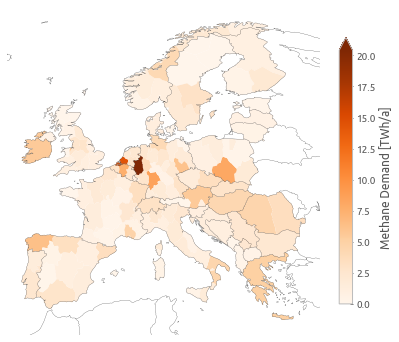

In [53]:
if GAS_NETWORK:
    plot_regional_demands(demand_by_region, nodes, "gas")

## Maps: system-level demands

In [54]:
def plot_system_demands(df, shape, carrier):

    shape["value"] = df.filter(regex=regex[carrier]).sum(axis=1).loc["EU"]

    proj = ccrs.EqualEarth()
    shape = shape.to_crs(proj.proj4_init)

    fig, ax = plt.subplots(figsize=(7, 7), subplot_kw={"projection": proj})

    shape.plot(
        ax=ax,
        column=shape.value,
        # transform=ccrs.PlateCarree(),
        cmap=cmap[carrier],
        linewidths=0,
        vmin=0,
        vmax=shape.value.max() * 2,
        legend=True,
        legend_kwds={
            "label": title[carrier],
            "shrink": 0.7,
        },
    )

    ax.add_feature(cartopy.feature.COASTLINE.with_scale("50m"), linewidth=0.2, zorder=2)

    plt.gca().outline_patch.set_visible(False)
    ax.set_facecolor("white")

    plt.savefig(f"{OUTPUT}/demand-map-{carrier}.pdf", bbox_inches="tight")

/tmp/ipykernel_42971/1351603410.py:27: DeprecationWarning:

The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning:

__len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning:

Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning:

__len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `

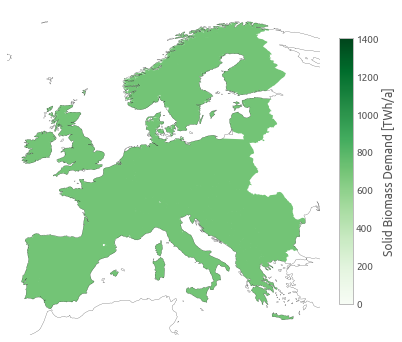

In [55]:
plot_system_demands(demand_by_region, europe_shape, "solid biomass")

/tmp/ipykernel_42971/1351603410.py:27: DeprecationWarning:

The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning:

__len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning:

Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning:

__len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `

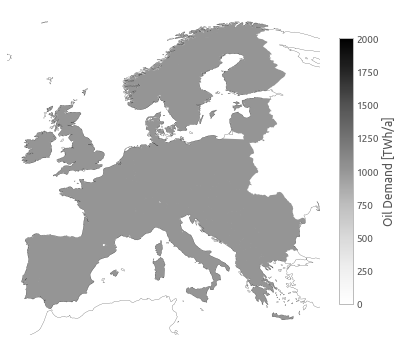

In [56]:
plot_system_demands(demand_by_region, europe_shape, "oil")

## Capacity Factors Renewables

In [57]:
df = (
    n.generators_t.p_max_pu.mean()
    .groupby([n.generators.carrier, n.generators.bus.map(n.buses.location)])
    .first()
    .unstack(0)
    .mul(100)
)

In [58]:
cop = (
    n.links_t.efficiency.mean()
    .groupby([n.links.carrier, n.links.bus0.map(n.buses.location)])
    .first()
    .unstack(0)
)

In [59]:
df["ground-sourced heat pump"] = cop.filter(like="ground").mean(axis=1)
df["air-sourced heat pump"] = cop.filter(like="air").mean(axis=1)

In [60]:
df["solar thermal"] = df.filter(like="solar thermal").mean(axis=1)

In [61]:
techs = [
    "offwind-ac",
    "offwind-dc",
    "onwind",
    "solar",
    "solar thermal",
    "ror",
    "air-sourced heat pump",
    "ground-sourced heat pump",
]
df = df[techs]

In [62]:
def plot_capacity_factors(
    df,
    geodf,
    carrier,
    cmap="Blues",
    vmax=100,
    vmin=0,
    label="capacity factors [%]",
    fn=None,
):

    proj = ccrs.EqualEarth()
    geodf = geodf.to_crs(proj.proj4_init)

    fig, ax = plt.subplots(figsize=(7, 7), subplot_kw={"projection": proj})

    geodf.plot(
        ax=ax,
        column=df[carrier].reindex(geodf.index),
        cmap=cmap,
        linewidths=0,
        legend=True,
        vmax=vmax,
        vmin=vmin,
        legend_kwds={
            "label": label,
            "shrink": 0.7,
            # "extend": "max",
        },
    )

    ax.add_feature(cartopy.feature.COASTLINE.with_scale("50m"), linewidth=0.2, zorder=2)
    ax.add_feature(cartopy.feature.BORDERS.with_scale("50m"), linewidth=0.2, zorder=2)

    plt.gca().outline_patch.set_visible(False)
    ax.set_facecolor("white")

    if fn is None:
        plt.savefig(f"{OUTPUT}/cf-{carrier}.pdf", bbox_inches="tight")

/tmp/ipykernel_42971/625614792.py:35: DeprecationWarning:

The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning:

__len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning:

Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning:

__len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `g

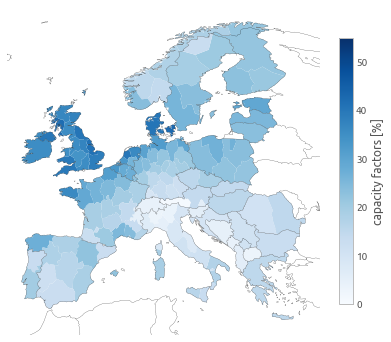

In [63]:
plot_capacity_factors(df, nodes, "onwind", vmax=55)

/tmp/ipykernel_42971/625614792.py:35: DeprecationWarning:

The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning:

__len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning:

Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning:

__len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `g

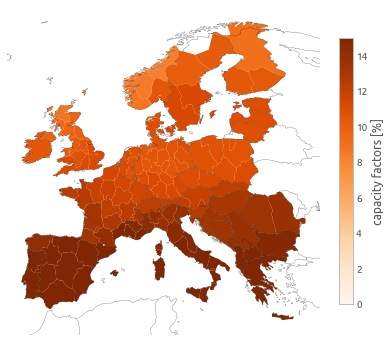

In [64]:
plot_capacity_factors(df, nodes, "solar", "Oranges", vmax=15)

/tmp/ipykernel_42971/625614792.py:35: DeprecationWarning:

The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning:

__len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning:

Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning:

__len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `g

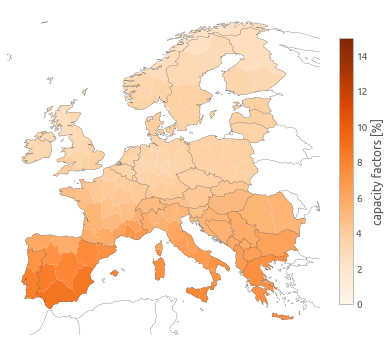

In [65]:
plot_capacity_factors(df, nodes, "solar thermal", "Oranges", vmax=15)

/tmp/ipykernel_42971/625614792.py:35: DeprecationWarning:

The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning:

__len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning:

Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning:

__len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `g

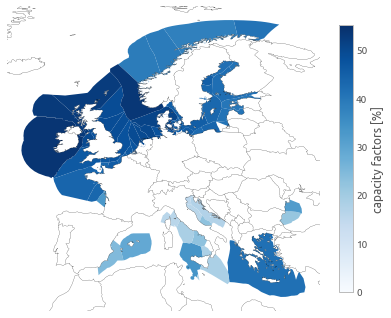

In [66]:
plot_capacity_factors(df, offnodes, "offwind-dc", vmax=55)

/tmp/ipykernel_42971/625614792.py:35: DeprecationWarning:

The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning:

__len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning:

Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning:

__len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `g

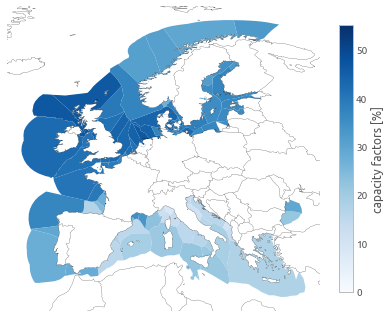

In [67]:
plot_capacity_factors(df, offnodes, "offwind-ac", vmax=55)

/tmp/ipykernel_42971/625614792.py:35: DeprecationWarning:

The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning:

__len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning:

Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning:

__len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `g

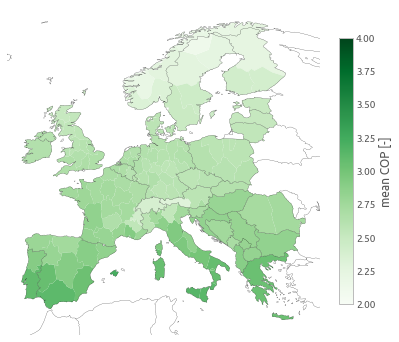

In [68]:
plot_capacity_factors(
    df,
    nodes,
    "air-sourced heat pump",
    cmap="Greens",
    vmax=4,
    vmin=2,
    label="mean COP [-]",
)

/tmp/ipykernel_42971/625614792.py:35: DeprecationWarning:

The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning:

__len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning:

Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning:

__len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `g

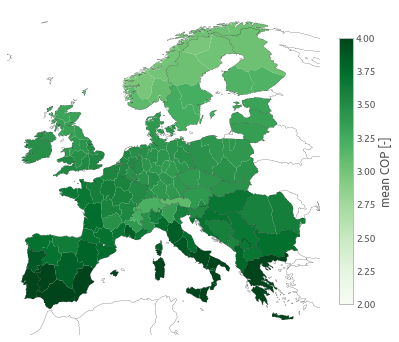

In [69]:
plot_capacity_factors(
    df,
    nodes,
    "ground-sourced heat pump",
    cmap="Greens",
    vmax=4,
    vmin=2,
    label="mean COP [-]",
)

## Demand Totals

In [10]:
mapping = {
    "H2 for industry": "hydrogen",
    "H2 for shipping": "hydrogen",
    "agriculture electricity": "electricity",
    "agriculture heat": "heat",
    "agriculture machinery oil": "oil",
    "agriculture machinery oil emissions": "emissions",
    "electricity": "electricity",
    "gas for industry": "methane",
    "industry electricity": "electricity",
    "kerosene for aviation": "oil",
    "land transport EV": "electricity",
    "land transport fuel cell": "hydrogen",
    "low-temperature heat for industry": "heat",
    "naphtha for industry": "oil",
    "oil emissions": "emissions",
    "process emissions": "emissions",
    "residential rural heat": "heat",
    "residential urban decentral heat": "heat",
    "services rural heat": "heat",
    "services urban decentral heat": "heat",
    "solid biomass for industry": "solid biomass",
    "urban central heat": "heat",
    "NH3": "ammonia",
}

In [11]:
mapping_sector = {
    "H2 for industry": ("hydrogen", "industry"),
    "H2 for shipping": ("hydrogen", "shipping"),
    "agriculture electricity": ("electricity", "agriculture"),
    "agriculture heat": ("heat", "agriculture"),
    "agriculture machinery oil": ("oil", "agriculture"),
    "agriculture machinery oil emissions": ("emissions", "agriculture"),
    "electricity": ("electricity", "residential"),
    "gas for industry": ("methane", "industry"),
    "industry electricity": ("electricity", "industry"),
    "kerosene for aviation": ("oil", "aviation"),
    "land transport EV": ("electricity", "land transport"),
    "land transport fuel cell": ("hydrogen", "land transport"),
    "low-temperature heat for industry": ("heat", "industry"),
    "naphtha for industry": ("oil", "industry"),
    "oil emissions": ("emissions", "other"),
    "process emissions": ("emissions", "process"),
    "residential rural heat": ("heat", "residential rural"),
    "residential urban decentral heat": ("heat", "residential urban"),
    "services rural heat": ("heat", "services rural"),
    "services urban decentral heat": ("heat", "services urban"),
    "solid biomass for industry": ("solid biomass", "industry"),
    "urban central heat": ("heat", "district heating"),
    "NH3": ("ammonia", "industry"),
}

In [12]:
order = [
    "electricity",
    "heat",
    "oil",
    "solid biomass",
    "methane",
    "hydrogen",
    "ammonia",
]

In [18]:
df = demand_by_region.sum()

In [19]:
df.index = pd.MultiIndex.from_tuples([(mapping[i], i) for i in df.index])

In [20]:
df.drop("emissions", inplace=True)

/tmp/ipykernel_117333/2335913672.py:1: PerformanceWarning:

dropping on a non-lexsorted multi-index without a level parameter may impact performance.



In [21]:
colors = config["plotting"]["tech_colors"]
colors["solid biomass"] = "seagreen"
colors["methane"] = "#db6a25"

In [25]:
df.groupby(level=0).sum().div(1e3).sum()

10.463360746208524

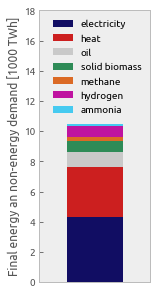

In [22]:
pd.DataFrame(df.groupby(level=0).sum().div(1e3).loc[order], columns=[""]).T.plot.bar(
    stacked=True,
    color=colors,
    figsize=(2, 5),
    ylim=[0, 18],
    ylabel="Final energy an non-energy demand [1000 TWh]",
)
plt.savefig(f"{OUTPUT}/total-annual-demand.pdf", bbox_inches="tight")

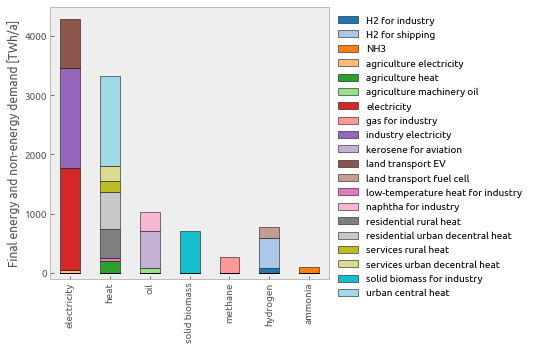

In [89]:
fig, ax = plt.subplots(figsize=(5, 5))

df.unstack().loc[order].plot.bar(
    ax=ax, stacked=True, cmap="tab20", edgecolor="k", ylim=(-100, 4500)
)

plt.legend(bbox_to_anchor=(1, 1))

plt.ylabel("Final energy and non-energy demand [TWh/a]")

plt.savefig(f"{OUTPUT}/demand-by-carrier.pdf")

In [90]:
df = demand_by_region.sum()

In [91]:
df.index = pd.MultiIndex.from_tuples([mapping_sector[i] for i in df.index])

In [92]:
df = df.loc[df > 0]

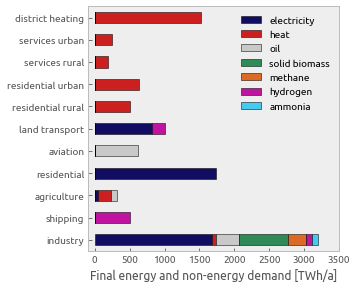

In [93]:
fig, ax = plt.subplots(figsize=(4.5, 4.5))

df.unstack().loc[order].T.plot.barh(
    ax=ax, color=colors, stacked=True, edgecolor="k", xlim=(-100, 3500)
)

plt.legend(bbox_to_anchor=(1, 1))

plt.xlabel("Final energy and non-energy demand [TWh/a]")

plt.savefig(f"{OUTPUT}/demand-by-sector-carrier.pdf")

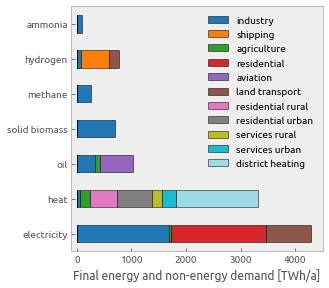

In [94]:
fig, ax = plt.subplots(figsize=(4.5, 4.5))

df.unstack().loc[order].plot.barh(
    ax=ax, stacked=True, cmap="tab20", edgecolor="k", xlim=(-100, 4500)
)

plt.legend(bbox_to_anchor=(1, 1))

plt.xlabel("Final energy and non-energy demand [TWh/a]")

plt.savefig(f"{OUTPUT}/demand-by-carrier-sector.pdf")

In [95]:
if not GAS_NETWORK:
    plot_system_demands(demand_by_region, europe_shape, "gas")

## Demand Time Series

In [96]:
kwargs = dict(ylim=[0, 1], xlabel="", figsize=(8, 2))

In [97]:
trans = n.loads_t.p_set.filter(like="land transport EV").sum(axis=1)
trans /= trans.max()

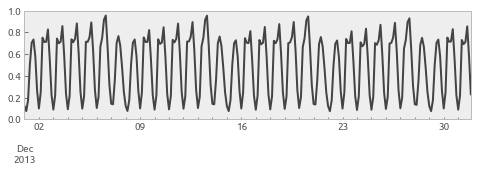

In [98]:
trans["12-2013"].plot(**kwargs, c="#444444")
plt.savefig(f"{OUTPUT}/bev-demand-month.pdf", bbox_inches="tight")

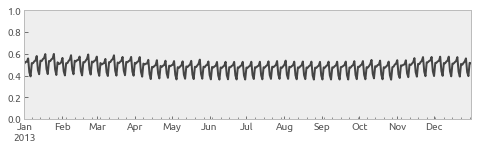

In [99]:
trans.resample("D").mean().plot(**kwargs, c="#444444")
plt.savefig(f"{OUTPUT}/bev-demand-year.pdf", bbox_inches="tight")

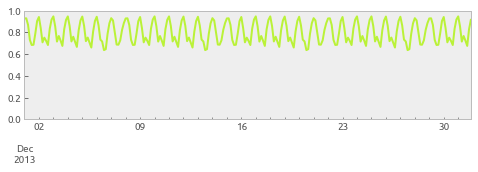

In [100]:
avail = n.links_t.p_max_pu.mean(axis=1)
avail["12-2013"].plot(**kwargs, c="#baf238")
plt.savefig(f"{OUTPUT}/bev-availability-month.pdf", bbox_inches="tight")

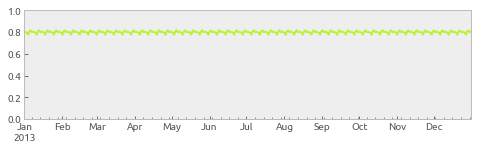

In [101]:
avail.resample("D").mean().plot(**kwargs, c="#baf238")
plt.savefig(f"{OUTPUT}/bev-availability-year.pdf", bbox_inches="tight")

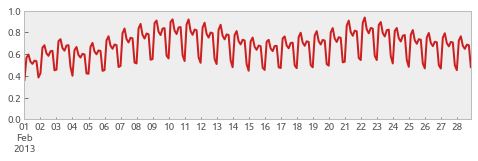

In [102]:
heat = n.loads_t.p_set.filter(like="heat").sum(axis=1)
heat /= heat.max()
heat["02-2013"].plot(**kwargs, c="#cc1f1f")
plt.savefig(f"{OUTPUT}/heat-demand-month.pdf", bbox_inches="tight")

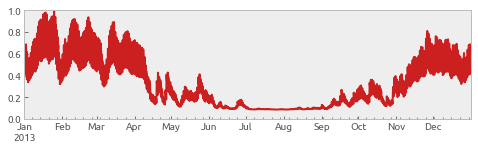

In [103]:
heat.plot(**kwargs, c="#cc1f1f")
plt.savefig(f"{OUTPUT}/heat-demand-year.pdf", bbox_inches="tight")

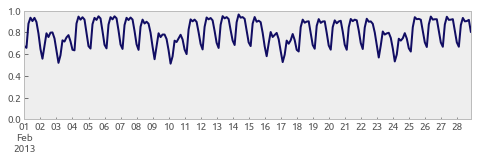

In [104]:
elec = n.loads_t.p_set.loc[
    :, n.loads.bus.map(n.buses.carrier).isin(["AC", "low voltage"])
].sum(axis=1)
elec /= elec.max()
elec["02-2013"].plot(**kwargs, c="#110d63")
plt.savefig(f"{OUTPUT}/elec-demand-month.pdf", bbox_inches="tight")

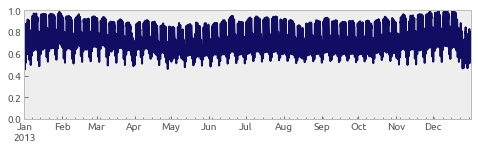

In [105]:
elec.plot(**kwargs, c="#110d63")
plt.savefig(f"{OUTPUT}/elec-demand-year.pdf", bbox_inches="tight")

In [106]:
loads = as_dense(n, "Load", "p_set")

In [107]:
heat = loads.filter(like="heat").sum(axis=1).div(1e3)

In [108]:
elec_nodes = n.loads.bus.map(n.buses.carrier).isin(
    ["AC", "low voltage", "Li ion", "battery"]
)

In [109]:
elec = loads.loc[:, elec_nodes].sum(axis=1).div(1e3)  # GW

In [110]:
gas_nodes = n.loads.bus.map(n.buses.carrier).isin(["gas", "biogas", "gas for industry"])
gas = loads.loc[:, gas_nodes].sum(axis=1).div(1e3)  # GW

In [111]:
h2_nodes = n.loads.bus.map(n.buses.carrier).isin(["H2", "H2 liquid"])
h2 = loads.loc[:, h2_nodes].sum(axis=1).div(1e3)  # GW

In [112]:
bio_nodes = n.loads.bus.map(n.buses.carrier).isin(
    ["solid biomass", "solid biomass for industry"]
)
bio = loads.loc[:, bio_nodes].sum(axis=1).div(1e3)  # GW

In [113]:
oil_nodes = n.loads.bus.map(n.buses.carrier).isin(["oil"])
oil = loads.loc[:, oil_nodes].sum(axis=1).div(1e3)  # GW

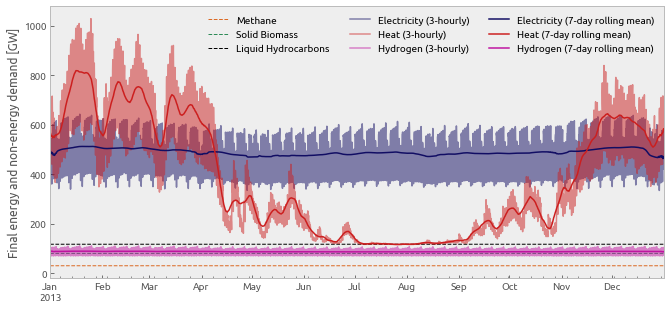

In [114]:
fig, ax = plt.subplots(figsize=(11, 5))

gas.plot(ax=ax, color="#db6a25", label="Methane", linestyle="--", linewidth=1)
bio.plot(ax=ax, color="seagreen", label="Solid Biomass", linestyle="--", linewidth=1)
oil.plot(ax=ax, color="k", label="Liquid Hydrocarbons", linestyle="--", linewidth=1)

elec.plot(
    ax=ax, color="#110d63", alpha=0.5, label="Electricity (3-hourly)", linewidth=1.5
)
heat.plot(ax=ax, color="#cc1f1f", alpha=0.5, label="Heat (3-hourly)", linewidth=1.5)
h2.plot(ax=ax, color="#bf13a0", alpha=0.5, label="Hydrogen (3-hourly)", linewidth=1.5)


elec.rolling(window="7D", center=True).mean().plot(
    ax=ax, color="#110d63", label="Electricity (7-day rolling mean)", linewidth=1.5
)
heat.rolling(window="7D", center=True).mean().plot(
    ax=ax, color="#cc1f1f", label="Heat (7-day rolling mean)", linewidth=1.5
)
h2.rolling(window="7D", center=True).mean().plot(
    ax=ax, color="#bf13a0", label="Hydrogen (7-day rolling mean)", linewidth=1.5
)

plt.xlabel("")
plt.legend(ncol=3)
plt.ylabel("Final energy and non-energy demand [GW]")

plt.savefig(f"{OUTPUT}/ts-demand.pdf", bbox_inches="tight")

## CO2

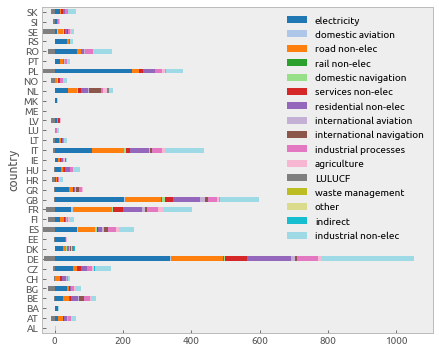

In [115]:
co2 = pd.read_csv(PATH + "pypsa-eur-sec/resources/co2_totals.csv", index_col=0)

fig, ax = plt.subplots(figsize=(7, 6))
co2.plot.barh(ax=ax, stacked=True, cmap="tab20")
plt.savefig(OUTPUT + "/co2.pdf")

## Industrial Production Fuel Switching

In [116]:
fn = PATH + "pypsa-eur-sec/resources/industrial_production_per_country.csv"
iproduction_today = pd.read_csv(fn, index_col=0).sum()

fn = (
    PATH + "pypsa-eur-sec/resources/industrial_production_per_country_tomorrow_2030.csv"
)
iproduction_tomorrow = pd.read_csv(fn, index_col=0).sum()

fn = PATH + "pypsa-eur-sec/resources/industry_sector_ratios.csv"
iratios = pd.read_csv(fn, index_col=0)

fn = PATH + "pypsa-eur-sec/resources/industrial_energy_demand_per_country_today.csv"
ienergy_today = (
    pd.read_csv(
        fn,
        index_col=0,
        header=[0, 1],
    )
    .groupby(level=1, axis=1)
    .sum()
)

In [117]:
ienergy_today.rename({"gas": "methane"}, inplace=True)

In [118]:
iratios.rename({"elec": "electricity", "naphtha": "liquid"}, inplace=True)
iratios.loc["solid", :] = iratios.loc[["coke", "coal"]].sum()
iratios.drop(
    ["coke", "coal", "process emission", "process emission from feedstock"],
    axis=0,
    inplace=True,
)

In [119]:
ienergy_tomorrow = iratios * iproduction_tomorrow / 1e3
bc = [
    "Chlorine",
    "HVC",
    "HVC (mechanical recycling)",
    "HVC (chemical recycling)",
    "Methanol",
]

In [120]:
ienergy_tomorrow["Basic chemicals (without ammonia)"] = ienergy_tomorrow[bc].sum(axis=1)
ienergy_tomorrow.drop(bc, axis=1, inplace=True)
ienergy_today["DRI + Electric arc"] = 0.0
ienergy_today.loc["hydrogen", :] = 0.0
ienergy_tomorrow.loc["other", :] = 0.0
ienergy_tomorrow.loc["waste", :] = 0.0

In [121]:
ienergy_tomorrow.sort_index(axis=1, inplace=True)
ienergy_today.sort_index(axis=1, inplace=True)

ienergy_tomorrow.sort_index(axis=0, inplace=True)
ienergy_today.sort_index(axis=0, inplace=True)

In [122]:
tech_colors = config["plotting"]["tech_colors"]

In [123]:
tech_colors["electricity"] = "#ace37f"
tech_colors["hydrogen"] = "#f073da"

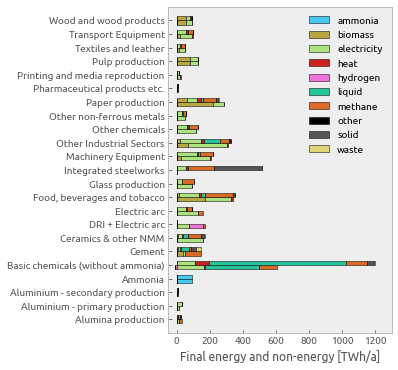

In [124]:
fig, ax = plt.subplots(figsize=(4, 6))

ienergy_tomorrow.T.plot.barh(
    ax=ax, stacked=True, width=0.3, color=tech_colors, position=1, edgecolor="k"
)
ienergy_today.T.plot.barh(
    ax=ax, stacked=True, width=0.3, color=tech_colors, position=0, edgecolor="k"
)


plt.xlabel("Final energy and non-energy [TWh/a]")
plt.xlim(-50, 1300)
plt.ylim(-1, 23)
handles, labels = ax.get_legend_handles_labels()
n = ienergy_today.shape[0]
plt.legend(handles[:n], labels[:n])
plt.savefig(OUTPUT + "/fec_industry_today_tomorrow.pdf", bbox_inches="tight")

In [125]:
df = ienergy_tomorrow.sum(axis=1).sort_values(ascending=False)
df = df.loc[df > 0]

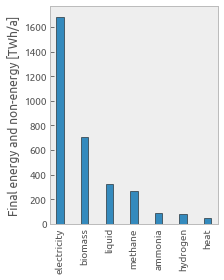

In [126]:
fig, ax = plt.subplots(figsize=(3, 4))

df.plot.bar(ax=ax, width=0.3, edgecolor="k")

plt.ylabel("Final energy and non-energy [TWh/a]")
plt.xlabel("")

plt.savefig(OUTPUT + "/fec_industry_tomorrow_by_carrier.pdf", bbox_inches="tight")

## Process Emissions

In [127]:
pe = (
    pd.read_csv(
        PATH + "pypsa-eur-sec/resources/industry_sector_ratios.csv", index_col=0
    )
    .filter(like="process emission", axis=0)
    .sum()
)

In [128]:
pe_today = iproduction_today * pe / 1e3

In [129]:
pe_tomorrow = iproduction_tomorrow * pe / 1e3

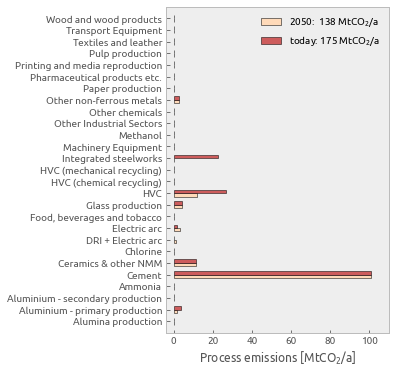

In [130]:
fig, ax = plt.subplots(figsize=(4, 6))

pe_tomorrow.plot.barh(ax=ax, width=0.3, color="peachpuff", position=1, edgecolor="k")
pe_today.plot.barh(ax=ax, width=0.3, color="indianred", position=0, edgecolor="k")

plt.xlabel(f"Process emissions [MtCO$_2$/a]")
plt.xlim(-4, 110)
plt.ylim(-1, 27)
handles, labels = ax.get_legend_handles_labels()
plt.legend(
    handles[:n],
    [
        f"2050:  {pe_tomorrow.sum():.0f} MtCO$_2$/a",
        f"today: {pe_today.sum():.0f} MtCO$_2$/a",
    ],
)
plt.savefig(OUTPUT + "/process-emissions.pdf", bbox_inches="tight")

## Power Plants

In [131]:
df = pd.read_csv(PATH + "pypsa-eur/resources/powerplants.csv", index_col=0)

df = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat), crs="EPSG:4326")

df.Fueltype = df.Fueltype.str.strip().replace("CCGT, Thermal", "CCGT")

df = df.loc[~df.Fueltype.isin(["Other", "Pv", "Storage Technologies"])]

colors = {
    "Bioenergy": "#80c944",
    "CCGT": "#a85522",
    "Geothermal": "red",
    "Hard Coal": "black",
    "Lignite": "#826837",
    "Hydro": "#235ebc",
    "Nuclear": "#ff8c00",
    "OCGT": "#e0986c",
    "Oil": "#c9c9c9",
    "Waste": "purple",
}

crs = ccrs.AlbersEqualArea()

df = df.cx[-12:30, 35:72]
df = df.to_crs(crs.proj4_init)

fig, ax = plt.subplots(figsize=(9.5, 9.5), subplot_kw={"projection": crs})

ax.add_feature(cartopy.feature.COASTLINE.with_scale("50m"), linewidth=0.2, zorder=2)
ax.add_feature(cartopy.feature.BORDERS.with_scale("50m"), linewidth=0.2, zorder=2)

df.plot(
    ax=ax,
    column="Fueltype",
    markersize=df["Capacity"] / 35,
    alpha=0.75,
    legend=True,
    cmap=mcolors.ListedColormap(
        pd.Series(df.Fueltype.unique()).sort_values().map(colors).values
    ),
    legend_kwds=dict(title="Technology (size ~ capacity)", frameon=False),
)


plt.gca().outline_patch.set_visible(False)
ax.set_facecolor("white")
plt.savefig(OUTPUT + "/powerplants.pdf", bbox_inches="tight")

ValueError: Invalid RGBA argument: nan

ValueError: Invalid RGBA argument: nan

<Figure size 684x684 with 1 Axes>

## Hotmaps Industrial Sites

In [135]:
def prepare_hotmaps_database():
    """
    Load hotmaps database of industrial sites.
    """

    df = pd.read_csv(
        PATH + "pypsa-eur-sec/data/Industrial_Database.csv", sep=";", index_col=0
    )

    df[["srid", "coordinates"]] = df.geom.str.split(";", expand=True)

    # remove those sites without valid locations
    df.drop(df.index[df.coordinates.isna()], inplace=True)

    df["coordinates"] = gpd.GeoSeries.from_wkt(df["coordinates"])

    gdf = gpd.GeoDataFrame(df, geometry="coordinates", crs="EPSG:4326")

    return gdf

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning:

__len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning:

Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning:

__len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.

/tmp/ipykernel_42971/2090734095.py:23: DeprecationWarning:

The outline_patch property is 

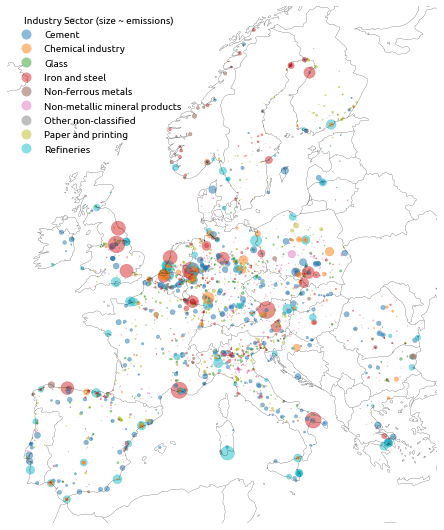

In [136]:
crs = ccrs.AlbersEqualArea()

hotmaps = prepare_hotmaps_database()
hotmaps = hotmaps.cx[-12:30, 35:72]
hotmaps = hotmaps.to_crs(crs.proj4_init)

fig, ax = plt.subplots(figsize=(9.5, 9.5), subplot_kw={"projection": crs})

ax.add_feature(cartopy.feature.COASTLINE.with_scale("50m"), linewidth=0.2, zorder=2)
ax.add_feature(cartopy.feature.BORDERS.with_scale("50m"), linewidth=0.2, zorder=2)

hotmaps.plot(
    ax=ax,
    column="Subsector",
    markersize=hotmaps["Emissions_ETS_2014"] / 3e4,
    alpha=0.5,
    legend=True,
    # transform=ccrs.epsg(3395),
    legend_kwds=dict(title="Industry Sector (size ~ emissions)", frameon=False),
)


plt.gca().outline_patch.set_visible(False)
ax.set_facecolor("white")

plt.savefig(OUTPUT + "/hotmaps.pdf", bbox_inches="tight")

## Salt Caverns

In [138]:
cavern_nodes = pd.read_csv(
    f"{PATH}/pypsa-eur-sec/resources/salt_cavern_potentials_s_{CLUSTERS}.csv",
    index_col=0,
)
cavern_nodes = cavern_nodes.where(cavern_nodes > 0.5)

In [140]:
cavern_regions = gpd.read_file(
    f"{PATH}/pypsa-eur/resources/regions_onshore_elec_s_{CLUSTERS}.geojson"
).set_index("name")

In [142]:
cavern_offregions = gpd.read_file(
    f"{PATH}/pypsa-eur/resources/regions_offshore_elec_s_{CLUSTERS}.geojson"
).set_index("name")

In [143]:
cavern_regions.to_crs(crs.proj4_init).total_bounds

array([-797119.06258312, 3929177.84594498, 2291265.28115526,
       7785028.36499251])

In [144]:
def plot_salt_caverns_by_node(
    cavern_nodes,
    cavern_regions,
    storage_type="onshore",
    cmap="GnBu",
    vmin=1,
    vmax=3000,
    fn=None,
    label=r"H$_2$ Storage Potential [TWh]",
):

    crs = ccrs.EqualEarth()

    cavern_regions = cavern_regions.to_crs(crs.proj4_init)

    fig, ax = plt.subplots(figsize=(7, 7), subplot_kw={"projection": crs})

    cavern_regions.plot(
        ax=ax,
        column=cavern_nodes[storage_type].reindex(cavern_regions.index),
        # transform=ccrs.PlateCarree(),
        cmap=cmap,
        linewidths=0,
        legend=True,
        vmin=vmin,
        vmax=vmax,
        legend_kwds={
            "label": label,
            "shrink": 0.7,
            "extend": "max",
        },
        norm=mcolors.LogNorm(vmin=1, vmax=vmax),
    )

    plt.title(f"{storage_type.capitalize()} Salt Cavern H$_2$ Storage Potentials")

    plt.xlim(-1.2e6, 2.6e6)
    plt.ylim(4.3e6, 7.8e6)

    # plt.xlim(-14.5, 31.5)
    # plt.ylim(34, 72)

    ax.add_feature(cartopy.feature.COASTLINE.with_scale("50m"), linewidth=0.2, zorder=2)
    ax.add_feature(cartopy.feature.BORDERS.with_scale("50m"), linewidth=0.2, zorder=2)

    plt.gca().outline_patch.set_visible(False)
    ax.set_facecolor("white")

    if fn is None:
        plt.savefig(
            f"{OUTPUT}/cavern-potentials-{storage_type}.pdf", bbox_inches="tight"
        )

/tmp/ipykernel_42971/3015739142.py:46: DeprecationWarning:

The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning:

__len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning:

Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning:

__len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `

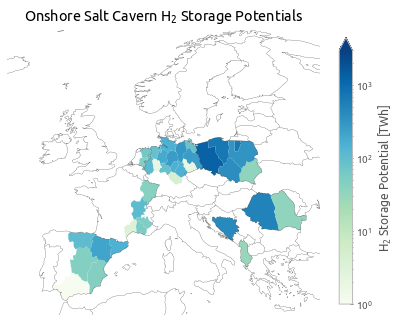

In [145]:
plot_salt_caverns_by_node(cavern_nodes, cavern_regions, storage_type="onshore")

/tmp/ipykernel_42971/3015739142.py:46: DeprecationWarning:

The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning:

__len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning:

Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning:

__len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `

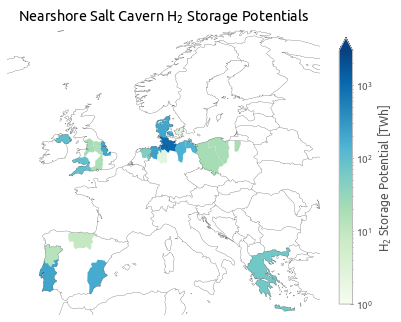

In [146]:
plot_salt_caverns_by_node(cavern_nodes, cavern_regions, storage_type="nearshore")

/tmp/ipykernel_42971/3015739142.py:46: DeprecationWarning:

The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning:

__len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning:

Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning:

__len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `

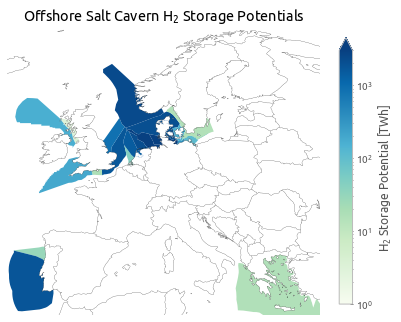

In [147]:
plot_salt_caverns_by_node(cavern_nodes, cavern_offregions, storage_type="offshore")

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning:

__len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning:

Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning:

__len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.

/tmp/ipykernel_42971/4164541080.py:30: DeprecationWarning:

The outline_patch property is 

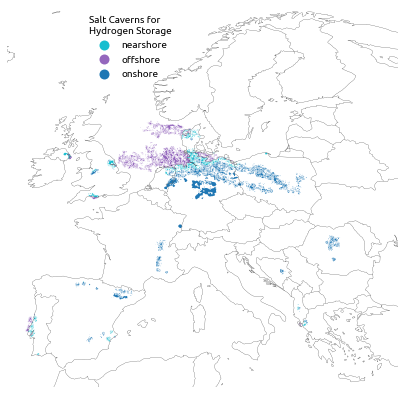

In [148]:
caverns = gpd.read_file(
    f"{PATH}/pypsa-eur-sec/data/h2_salt_caverns_GWh_per_sqkm.geojson"
)

crs = ccrs.EqualEarth()

caverns = caverns.to_crs(crs.proj4_init)

fig, ax = plt.subplots(figsize=(7, 7), subplot_kw={"projection": crs})

ax.add_feature(cartopy.feature.COASTLINE.with_scale("50m"), linewidth=0.2, zorder=2)
ax.add_feature(cartopy.feature.BORDERS.with_scale("50m"), linewidth=0.2, zorder=2)

caverns.plot(
    ax=ax,
    column="storage_type",
    cmap="tab10_r",  # "tab10_r",
    legend=True,
    linewidth=0,
    # transform=ccrs.epsg(3395),
    legend_kwds=dict(
        title="Salt Caverns for\nHydrogen Storage", frameon=False, loc=(0.2, 0.8)
    ),
)


plt.xlim(-1e6, 2.6e6)
plt.ylim(4.3e6, 7.8e6)

plt.gca().outline_patch.set_visible(False)
ax.set_facecolor("white")

plt.savefig(OUTPUT + "/caverns.pdf", bbox_inches="tight")

## Biomass potentials

In [149]:
fn = PATH + f"{PATH}/pypsa-eur-sec/resources/biomass_potentials_s_{CLUSTERS}.csv"
bio = pd.read_csv(fn, index_col=0).div(1e6)  # TWh/a

In [150]:
def plot_biomass_potentials(bio, nodes, kind, fn=None):

    crs = ccrs.EqualEarth()
    nodes = nodes.to_crs(crs.proj4_init)

    fig, ax = plt.subplots(figsize=(7, 7), subplot_kw={"projection": crs})

    ax.add_feature(cartopy.feature.COASTLINE.with_scale("50m"), linewidth=0.2, zorder=2)
    ax.add_feature(cartopy.feature.BORDERS.with_scale("50m"), linewidth=0.2, zorder=2)

    nkind = "disregarded biomass" if kind == "not included" else kind
    label = f"{nkind} potentials [TWh/a]"

    nodes.plot(
        ax=ax,
        column=bio[kind],
        cmap="Greens",  # "tab10_r",
        legend=True,
        linewidth=0,
        legend_kwds={
            "label": label,
            "shrink": 0.7,
            "extend": "max",
        },
    )

    total = bio[kind].sum()

    ax.text(-0.8e6, 7.4e6, f"total: {total:.0f} TWh/a", fontsize=15, color="#343434")

    plt.xlim(-1e6, 2.6e6)
    plt.ylim(4.3e6, 7.8e6)

    plt.gca().outline_patch.set_visible(False)
    ax.set_facecolor("white")

    if fn is None:
        plt.savefig(OUTPUT + f"/biomass-{kind}.pdf", bbox_inches="tight")

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning:

__len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning:

Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning:

__len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.

/tmp/ipykernel_42971/2735013166.py:34: DeprecationWarning:

The outline_patch property is 

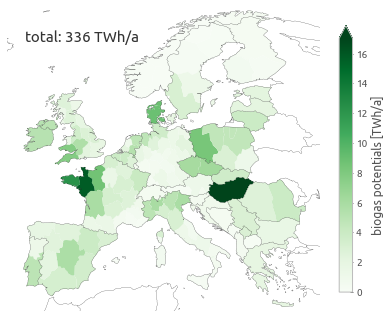

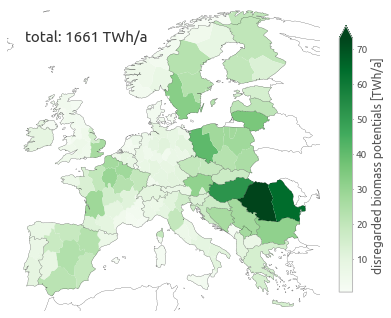

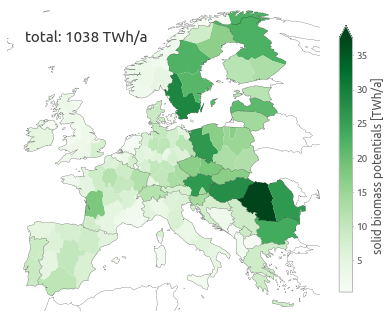

In [151]:
for kind in bio.columns:
    plot_biomass_potentials(bio, nodes, kind)

## Ammonia Production

In [152]:
fn = PATH + f"{PATH}/pypsa-eur-sec/resources/ammonia_production.csv"
df = pd.read_csv(fn, index_col=0)  # kt/a

In [153]:
def plot_ammonia_production(df, cts, year, fn=None):

    year = str(year)

    crs = ccrs.EqualEarth()
    cts = cts.to_crs(crs.proj4_init)

    fig, ax = plt.subplots(figsize=(7, 7), subplot_kw={"projection": crs})

    ax.add_feature(cartopy.feature.COASTLINE.with_scale("50m"), linewidth=0.2, zorder=2)
    ax.add_feature(cartopy.feature.BORDERS.with_scale("50m"), linewidth=0.2, zorder=2)

    cts.plot(
        ax=ax,
        column=df[year].reindex(cts.index),
        cmap="Purples",  # "tab10_r",
        legend=True,
        linewidth=0,
        legend_kwds={
            "label": "Ammonia Production [kt]",
            "shrink": 0.7,
        },
    )

    total = df[year].sum()
    ax.text(
        -0.85e6, 7.4e6, f"total: {total:.0f} kt ({year})", fontsize=12, color="#343434"
    )

    plt.xlim(-1e6, 2.6e6)
    plt.ylim(4.3e6, 7.8e6)

    plt.gca().outline_patch.set_visible(False)
    ax.set_facecolor("white")

    if fn is None:
        plt.savefig(OUTPUT + f"/ammonia-{year}.pdf", bbox_inches="tight")

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning:

__len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning:

Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning:

__len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.

/tmp/ipykernel_42971/1345715215.py:33: DeprecationWarning:

The outline_patch property is 

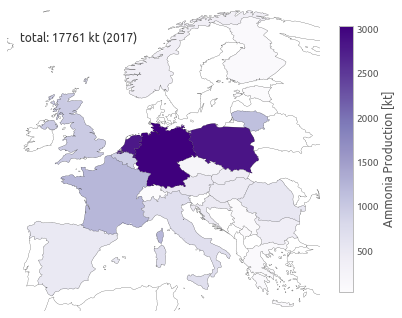

In [154]:
plot_ammonia_production(df, cts, 2017)

## Gas Network Unclustered

In [160]:
lng_fn = f"{PATH}pypsa-eur-sec/data/gas_network/scigrid-gas/data/IGGIELGN_LNGs.geojson"
entry_fn = (
    f"{PATH}pypsa-eur-sec/data/gas_network/scigrid-gas/data/IGGIELGN_BorderPoints.geojson"
)
prod_fn = (
    f"{PATH}pypsa-eur-sec/data/gas_network/scigrid-gas/data/IGGIELGN_Productions.geojson"
)
planned_lng_fn = PATH + "pypsa-eur-sec/data/gas_network/planned_LNGs.csv"

regions_onshore = f"{PATH}pypsa-eur/resources/regions_onshore_elec_s_{CLUSTERS}.geojson"
regions_offshore = f"{PATH}pypsa-eur/resources/regions_offshore_elec_s_{CLUSTERS}.geojson"

In [161]:
regions = load_bus_regions(regions_onshore, regions_offshore)

# add a buffer to eastern countries because some
# entry points are still in Russian or Ukrainian territory.
buffer = 9000  # meters
eastern_countries = ["FI", "EE", "LT", "LV", "PL", "SK", "HU", "RO"]
add_buffer_b = regions.index.str[:2].isin(eastern_countries)
regions.loc[add_buffer_b] = (
    regions[add_buffer_b].to_crs(3035).buffer(buffer).to_crs(4326)
)

countries = regions.index.str[:2].unique().str.replace("GB", "UK")

In [162]:
pts = build_gas_input_locations(
    lng_fn,
    planned_lng_fn,
    entry_fn,
    prod_fn,
    countries,
)

In [163]:
sums = pts.groupby("type").p_nom.sum()

for t in ["lng", "production", "pipeline"]:
    pts.loc[pts["type"] == t, "p_nom"] /= sums[t]

In [164]:
pts["type"] = pts["type"].replace(
    dict(production="Fossil Extraction", lng="LNG Terminal", pipeline="Entrypoint")
)

In [165]:
fn = PATH + "pypsa-eur-sec/resources/gas_network.csv"
df = pd.read_csv(fn, index_col=0)
for col in ["geometry"]:
    df[col] = df[col].apply(wkt.loads)

df = gpd.GeoDataFrame(df, geometry="geometry", crs="EPSG:4326")

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning:

__len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning:

Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning:

__len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:82

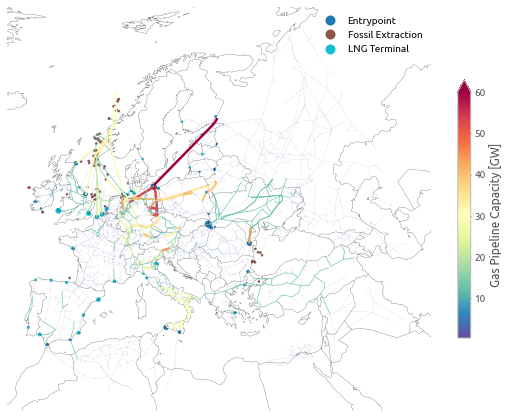

In [166]:
crs = ccrs.AlbersEqualArea()

df = df.to_crs(crs.proj4_init)
pts = pts.to_crs(crs.proj4_init)

fig, ax = plt.subplots(figsize=(9.5, 9.5), subplot_kw={"projection": crs})

ax.add_feature(cartopy.feature.COASTLINE.with_scale("50m"), linewidth=0.2, zorder=2)
ax.add_feature(cartopy.feature.BORDERS.with_scale("50m"), linewidth=0.2, zorder=2)

df.plot(
    ax=ax,
    column=df["p_nom"].div(1e3),
    linewidths=df["p_nom"].clip(upper=50e3).div(2e4),
    cmap="Spectral_r",
    vmax=60,
    legend=True,
    legend_kwds=dict(label="Gas Pipeline Capacity [GW]", shrink=0.5, extend="max"),
)

pts.plot(
    ax=ax,
    column="type",
    markersize=pts["p_nom"] * 300,
    legend=True,
)


plt.gca().outline_patch.set_visible(False)
ax.set_facecolor("white")
plt.savefig(OUTPUT + "/gas_network.pdf", bbox_inches="tight")